In [1]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
coral_seg = "jackhowell/coral_seg"

In [4]:
from datasets import load_dataset

dataset = load_dataset(coral_seg)

In [5]:
dataset


DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label', 'id', 'image_path', 'mask_path', 'split'],
        num_rows: 333
    })
})

In [6]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [7]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=coral_seg, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'background', 1: 'hy', 2: 'nh', 3: 'nv', 4: 'st-zo', 5: 'ns'}


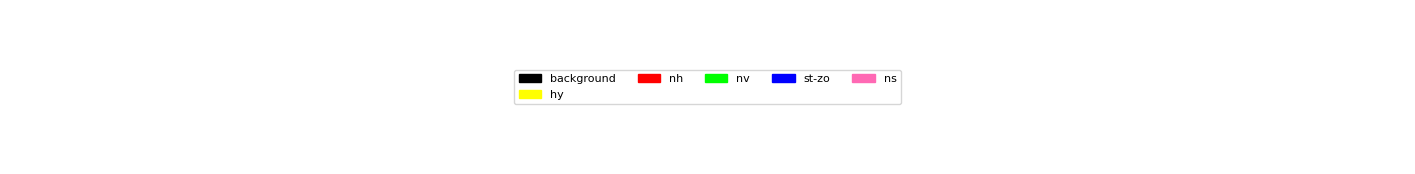

/tmp/ipykernel_1593273/1208676959.py:47: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  colored_mask_img = Image.fromarray(colored_mask, 'RGB')


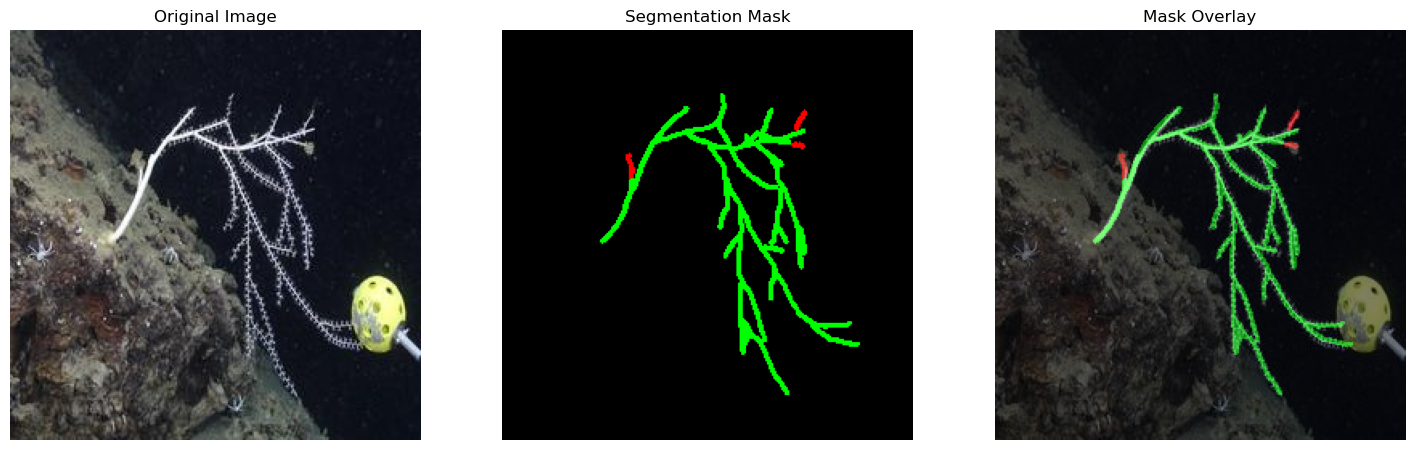

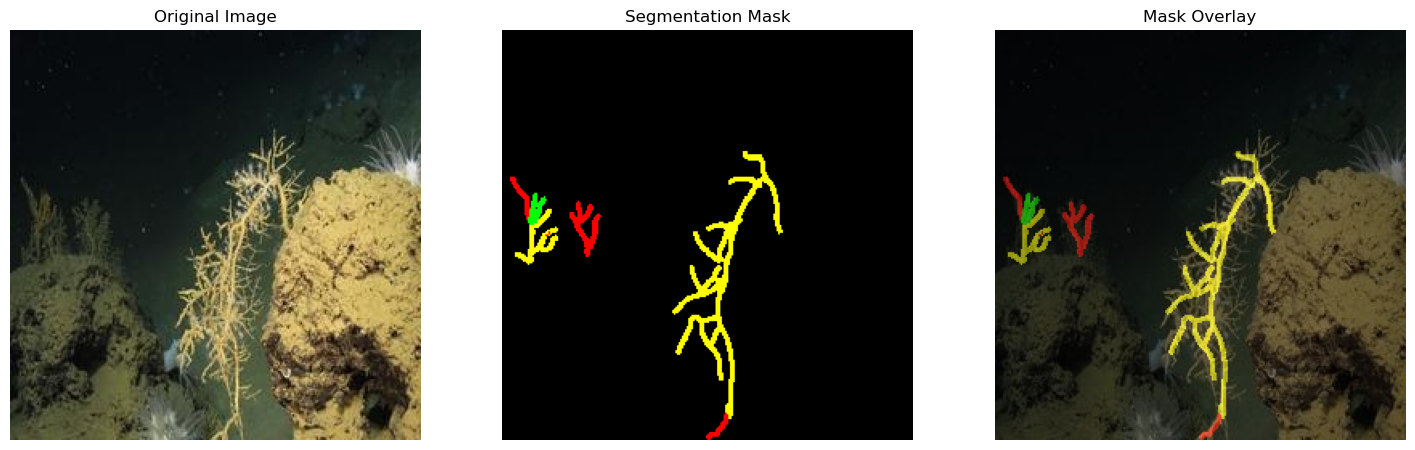

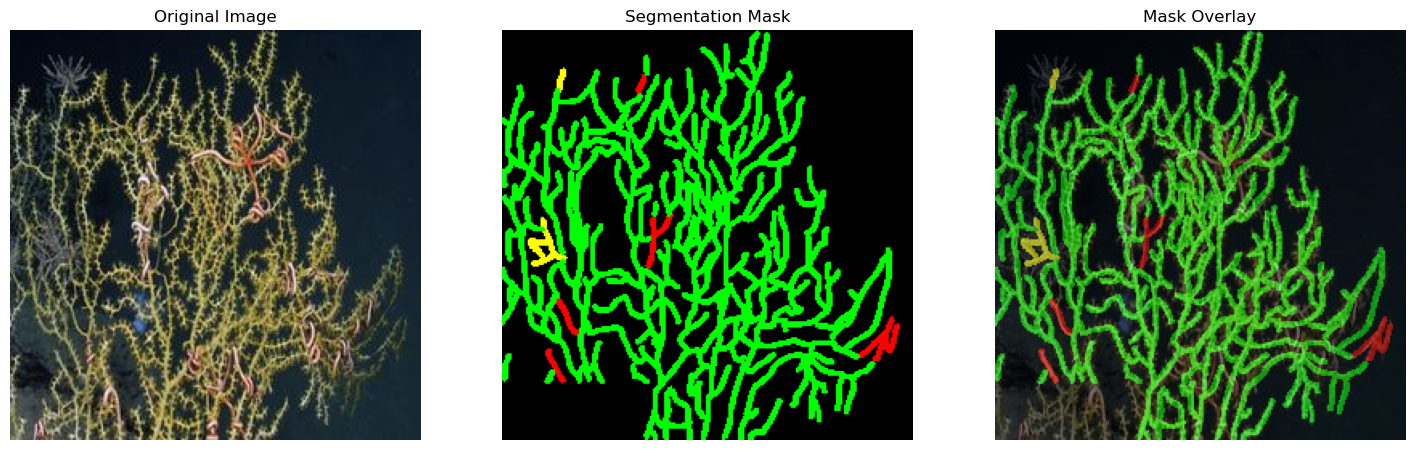

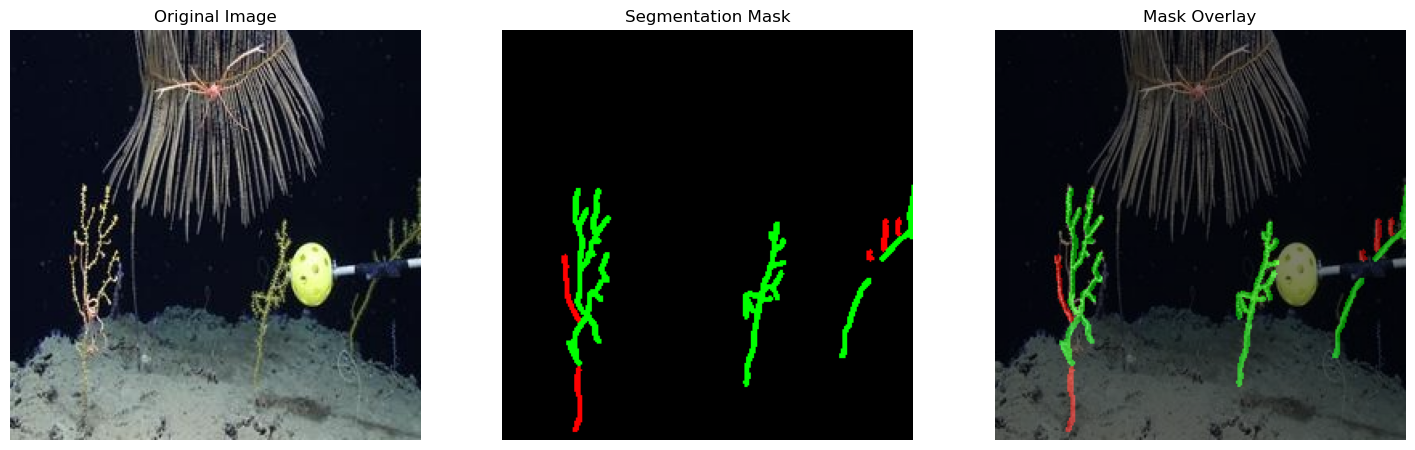

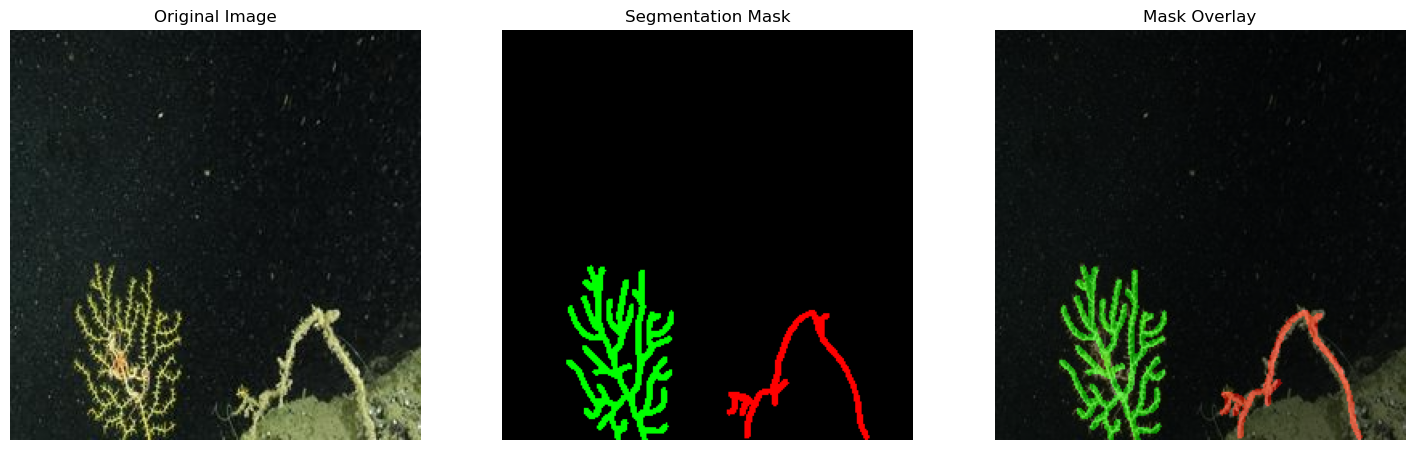

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Define your custom color palette (RGB tuples for each class)
# Order must match your id2label order: 0:'background', 1:'hy', 2:'nh', 3:'nv', 4:'st-zo', 5:'ns'

palette = [
    (0, 0, 0),        # 0: background – black
    (255, 255, 0),      # 1: hy (hydroid) – yellow
    (255, 0, 0),      # 2: nh (unmhealthy) – red
    (0, 255, 0),      # 3: nv (healthy) – green
    (0, 0, 255),    # 4: st-zo (stress/zooxanthellate) – blue
    (255, 105, 180),  # 5: ns (no signal / sediment) – pink
]

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [patches.Patch(color=np.array(color)/255, label=label) for label, color in zip(id2label.values(), palette)]

ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis('off')

plt.show()

for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Show the original image
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Show the segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Convert the original image to RGBA to support transparency
    image_rgba = image['pixel_values'].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask
    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Mask Overlay')
    ax[2].axis('off')

    plt.show()

In [9]:
import sys
print(sys.executable)

/home/jrhowell/.conda/envs/coral_seg/bin/python


In [10]:
from PIL import Image
print("Pillow is working ✅")

Pillow is working ✅


In [11]:
from PIL import Image
import PIL
print("✅ Pillow version:", PIL.__version__)

✅ Pillow version: 11.3.0


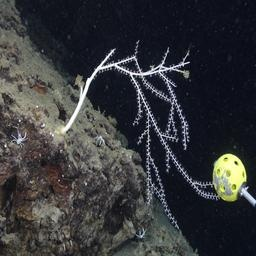

In [12]:
from datasets import Dataset, Image

image = dataset["train"][0]["pixel_values"]
image.show()

## 4. Visualize Class Occurrences 📊

To gain deeper insights into the dataset, let’s plot the occurrences of each class. This will allow us to understand the distribution of classes and identify any potential biases or imbalances in the dataset.


In [13]:
import numpy as np

num_classes = len(id2label)  # 6
class_counts = np.zeros(num_classes, dtype=np.int64)
unexpected = {}
bad_examples = []

def to_2d(mask_img):
    m = np.array(mask_img)
    if m.ndim == 3:
        m = m[..., 0]
    return m

for i, ex in enumerate(train_ds):
    m = to_2d(ex["label"])
    uniq, cnt = np.unique(m, return_counts=True)

    in_range = (uniq >= 0) & (uniq < num_classes)

    # vectorized integer-safe accumulation
    if np.any(in_range):
        tmp = np.zeros(num_classes, dtype=np.int64)
        tmp[uniq[in_range]] = cnt[in_range].astype(np.int64)
        class_counts += tmp

    if np.any(~in_range):
        bad_examples.append(i)
        for v, c in zip(uniq[~in_range], cnt[~in_range]):
            unexpected[int(v)] = unexpected.get(int(v), 0) + int(c)

print("class_counts:", class_counts)
print("unexpected labels summary:", unexpected)
print("examples with unexpected labels (first 10):", bad_examples[:10])

class_counts: [15260718   260162   421738  1415704    60306    13948]
unexpected labels summary: {}
examples with unexpected labels (first 10): []


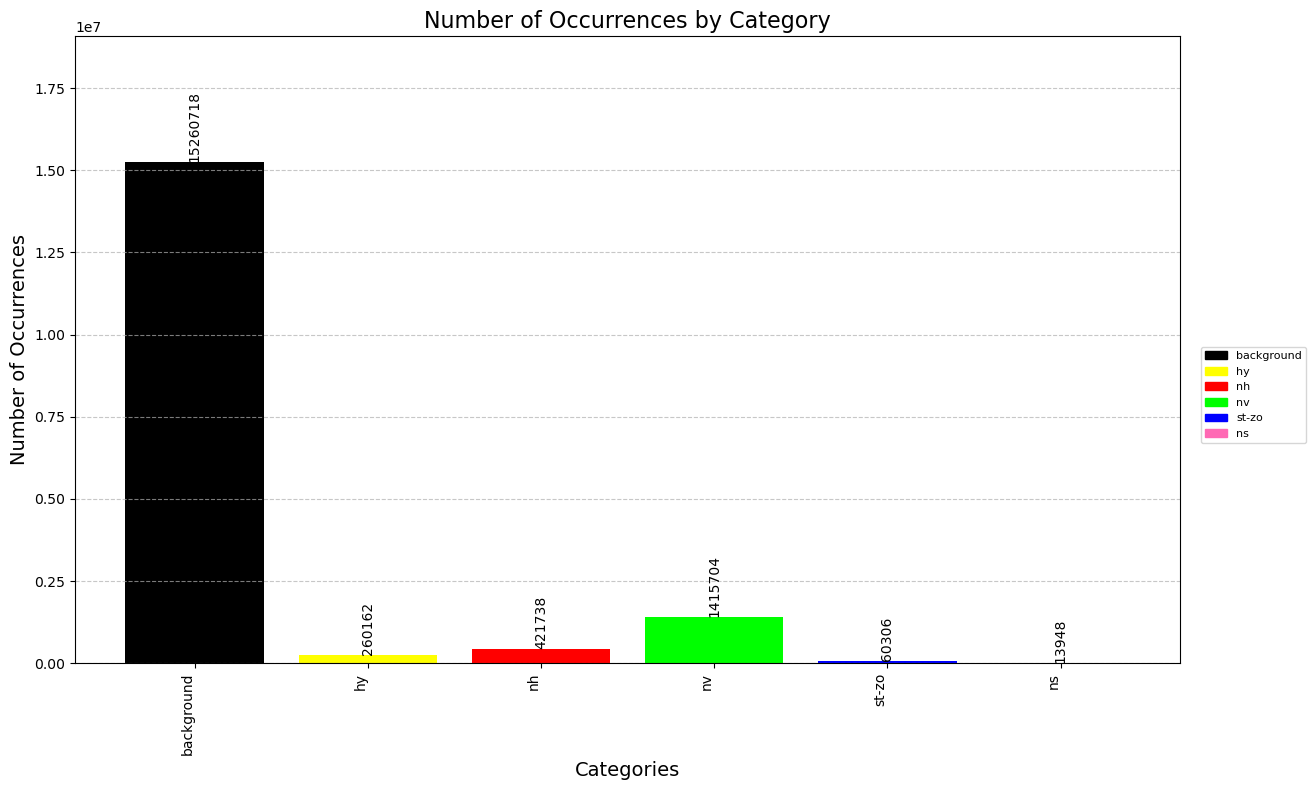

In [14]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in palette]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Adjust the text location
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f"{height}",
            ha="center", va="bottom", rotation=90, fontsize=10, color='black')

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8)  # Adjust ncol as needed

plt.tight_layout()
plt.show()

## 5. Initialize Image Processor and Add Data Augmentation with Albumentations 📸

We will start by initializing the image processor and then apply data augmentation 🪄 using [Albumentations](https://albumentations.ai/). This will help enhance our dataset and improve the performance of our semantic segmentation model.


In [15]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-30, 30), p=0.7),
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),  # ← fixed here
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(p=0.4),
])

def train_transforms(example_batch):
    augmented = [
        albumentations_transform(image=np.array(image), mask=np.array(label))
        for image, label in zip(example_batch['pixel_values'], example_batch['label'])
    ]
    augmented_images = [item['image'] for item in augmented]
    augmented_labels = [item['mask'] for item in augmented]
    inputs = image_processor(augmented_images, augmented_labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## 6. Initialize Model from Checkpoint

We will use a pretrained Segformer model from the checkpoint: [nvidia/mit-b0](https://huggingface.co/nvidia/mit-b0). This architecture is detailed in the paper [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203) and has been trained on ImageNet-1k.


In [16]:
from transformers import SegformerForSemanticSegmentation
output_dir = output_dir="./results"

pretrained_path = "nvidia/mit-b0"

checkpoint_path = output_dir + "/checkpoint-160" #path to checkpoint dir

model = SegformerForSemanticSegmentation.from_pretrained(
    checkpoint_path, # CHANGE!!
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # this suppresses the warning
)

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-3,
    num_train_epochs=27.20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    
    eval_strategy="steps",   
    eval_steps=20,                   
    logging_strategy="steps",        
    logging_steps=1,

    save_strategy="steps",
    save_steps=20,

    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    report_to="wandb",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

## 8. Set Custom `compute_metrics` Method for Enhanced Logging with `evaluate`

We will use the [mean Intersection over Union (mean IoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou) as the primary metric 
to evaluate the model’s performance. This will allow us to track performance across each category in detail.

Additionally, we’ll adjust the logging level of the evaluation module to minimize warnings in the output. If a category is not detected in an image, you might see warnings like the following:

```
RuntimeWarning: invalid value encountered in divide iou = total_area_intersect / total_area_union
```


You can skip this cell if you prefer to see these warnings and proceed to the next step.


In [18]:
import evaluate
evaluate.logging.set_verbosity_error()

In [19]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    pred_labels = logits_tensor.detach().cpu().numpy()
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

## 9. Train the Model on Our Dataset 🏋

Now it's time to train the model on our custom dataset. We’ll use the prepared training arguments and the connected Weights & Biases integration to monitor the training process and make adjustments as needed. Let’s start the training and watch the model improve its performance!


In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/tmp/ipykernel_1593273/112254033.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()
print(trainer.state.global_step)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jackrhowell16 (jackrhowell16-university-of-hawaii-system) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Hy,Accuracy Nh,Accuracy Nv,Accuracy St-zo,Accuracy Ns,Iou Background,Iou Hy,Iou Nh,Iou Nv,Iou St-zo,Iou Ns
20,0.372300,0.323766,0.000309,0.000370,0.001523,nan,0.000000,0.000000,0.001852,0.000000,0.000000,0.000000,0.000000,0.000000,0.001852,0.000000,0.000000
40,0.658900,0.344047,0.099380,0.128600,0.528788,nan,0.000000,0.000000,0.642999,0.000000,0.000000,0.000000,0.000000,0.000000,0.596280,0.000000,0.000000
60,0.311200,0.315239,0.062424,0.078067,0.321004,nan,0.000000,0.000000,0.390337,0.000000,0.000000,0.000000,0.000000,0.000000,0.374546,0.000000,0.000000
80,0.412100,0.319447,0.073415,0.092254,0.379337,nan,0.000000,0.000000,0.461269,0.000000,0.000000,0.000000,0.000000,0.000000,0.440489,0.000000,0.000000
100,0.378700,0.321897,0.031016,0.037781,0.155352,nan,0.000000,0.000000,0.188906,0.000000,0.000000,0.000000,0.000000,0.000000,0.186099,0.000000,0.000000
120,0.482700,0.328993,0.035809,0.043831,0.180227,nan,0.000000,0.000000,0.219154,0.000000,0.000000,0.000000,0.000000,0.000000,0.214854,0.000000,0.000000


120


In [22]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    pred_labels = logits_tensor.detach().cpu().numpy()
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

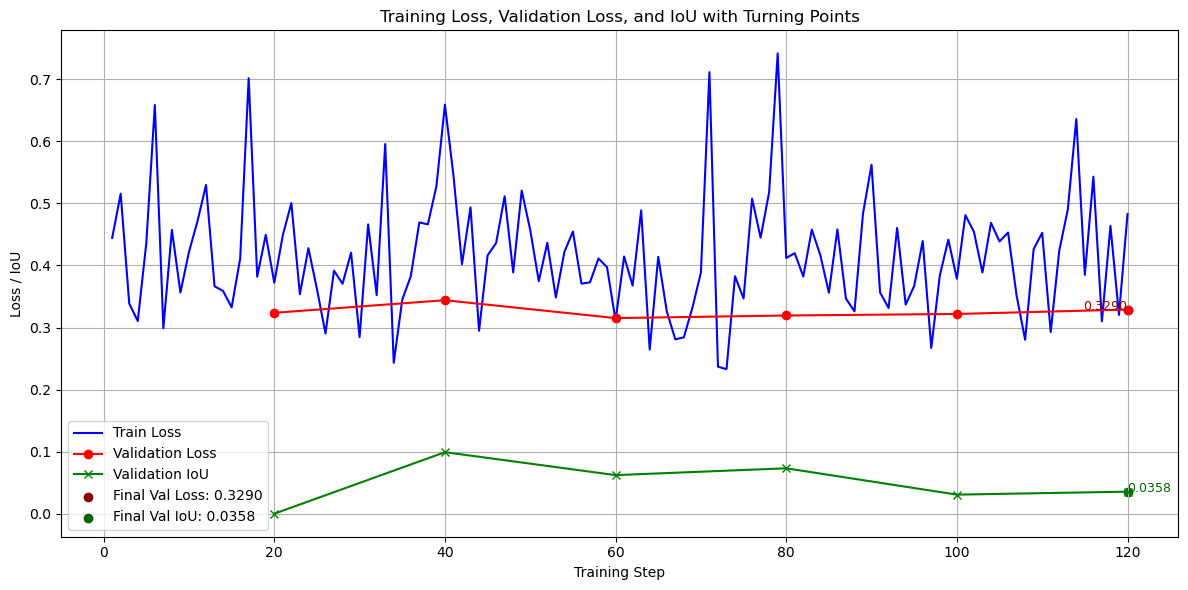

In [23]:
log_history = trainer.state.log_history

# Extract steps and losses
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
eval_ious = [log["eval_mean_iou"] for log in log_history if "eval_mean_iou" in log]
eval_steps = [log["step"] for log in log_history if "eval_loss" in log]
eval_iou_steps = [log["step"] for log in log_history if "eval_mean_iou" in log]

train_losses = [log["loss"] for log in log_history if "loss" in log]
train_steps = [log["step"] for log in log_history if "loss" in log]

# Set parameters
window = 3
n_quarters = 4
turning_points = []

# Divide evaluation indices into quarters
quarter_indices = [
    (i * len(eval_losses) // n_quarters, (i + 1) * len(eval_losses) // n_quarters)
    for i in range(n_quarters)
]

# Find first sustained increase in eval loss in each quarter
for q, (start_idx, end_idx) in enumerate(quarter_indices):
    for i in range(start_idx, end_idx - window):
        if all(eval_losses[i + j] < eval_losses[i + j + 1] for j in range(window)):
            turning_points.append((eval_steps[i + window], eval_losses[i + window]))
            break

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_losses, label="Train Loss", color="blue")
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="o", color="red")
plt.plot(eval_iou_steps, eval_ious, label="Validation IoU", marker="x", color="green")

# Highlight final validation loss
plt.scatter(eval_steps[-1], eval_losses[-1], color="darkred", label=f"Final Val Loss: {eval_losses[-1]:.4f}")
plt.text(eval_steps[-1], eval_losses[-1], f"{eval_losses[-1]:.4f}", color="darkred", fontsize=9, ha="right")

# Highlight final validation IoU
plt.scatter(eval_iou_steps[-1], eval_ious[-1], color="darkgreen", label=f"Final Val IoU: {eval_ious[-1]:.4f}")
plt.text(eval_iou_steps[-1], eval_ious[-1], f"{eval_ious[-1]:.4f}", color="darkgreen", fontsize=9, ha="left")

# Highlight turning points
for i, (step, loss) in enumerate(turning_points):
    plt.scatter(step, loss, color="orange", label=f"↑ Q{i+1} at step {step}")
    plt.text(step, loss, f"{loss:.4f}", color="orange", fontsize=9, ha="left")

plt.xlabel("Training Step")
plt.ylabel("Loss / IoU")
plt.title("Training Loss, Validation Loss, and IoU with Turning Points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print turning point epochs
steps_per_epoch = trainer.state.global_step // training_args.num_train_epochs
for i, (step, _) in enumerate(turning_points):
    approx_epoch = step / steps_per_epoch
    print(f"🔍 Q{i+1}: Sustained increase at step {step} → approx. epoch {approx_epoch:.2f}")

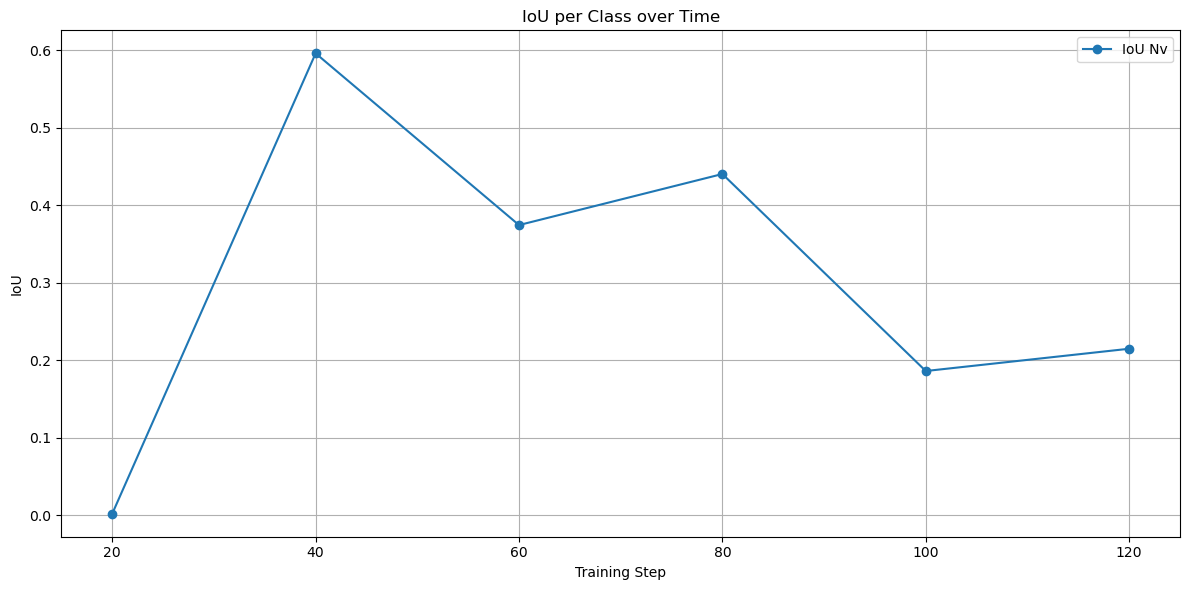

In [24]:
# Extract IoU metrics per class
eval_steps = [log["step"] for log in log_history if "eval_iou_nv" in log]

iou_nv = [log.get("eval_iou_nv", 0.0) for log in log_history if "eval_iou_nv" in log]
iou_nh = [log.get("eval_iou_nh", 0.0) for log in log_history if "eval_iou_nh" in log]
iou_hy = [log.get("eval_iou_hy", 0.0) for log in log_history if "eval_iou_hy" in log]
iou_ns = [log.get("eval_iou_ns", 0.0) for log in log_history if "eval_iou_ns" in log]
iou_stzo = [log.get("eval_iou_st-zo", 0.0) for log in log_history if "eval_iou_st-zo" in log]
iou_bg = [log.get("eval_iou_background", 0.0) for log in log_history if "eval_iou_background" in log]

# Optional: define color and label mappings
class_iou_data = {
    "Background": iou_bg,
    "Hy": iou_hy,
    "Nh": iou_nh,
    "Nv": iou_nv,
    "St-zo": iou_stzo,
    "Ns": iou_ns
}

# Plot
plt.figure(figsize=(12, 6))
for label, iou_values in class_iou_data.items():
    if any(iou_values):  # Only plot classes with non-zero or non-NaN values
        plt.plot(eval_steps, iou_values, marker='o', label=f"IoU {label}")

plt.xlabel("Training Step")
plt.ylabel("IoU")
plt.title("IoU per Class over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Evaluate Model Performance on New Images 📸

After training, we’ll assess the model’s performance on new images. We’ll use a test image and leverage a [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) to evaluate how well the model performs on unseen data.


🖼️ Using image: task_183.jpg


Device set to use cuda:0


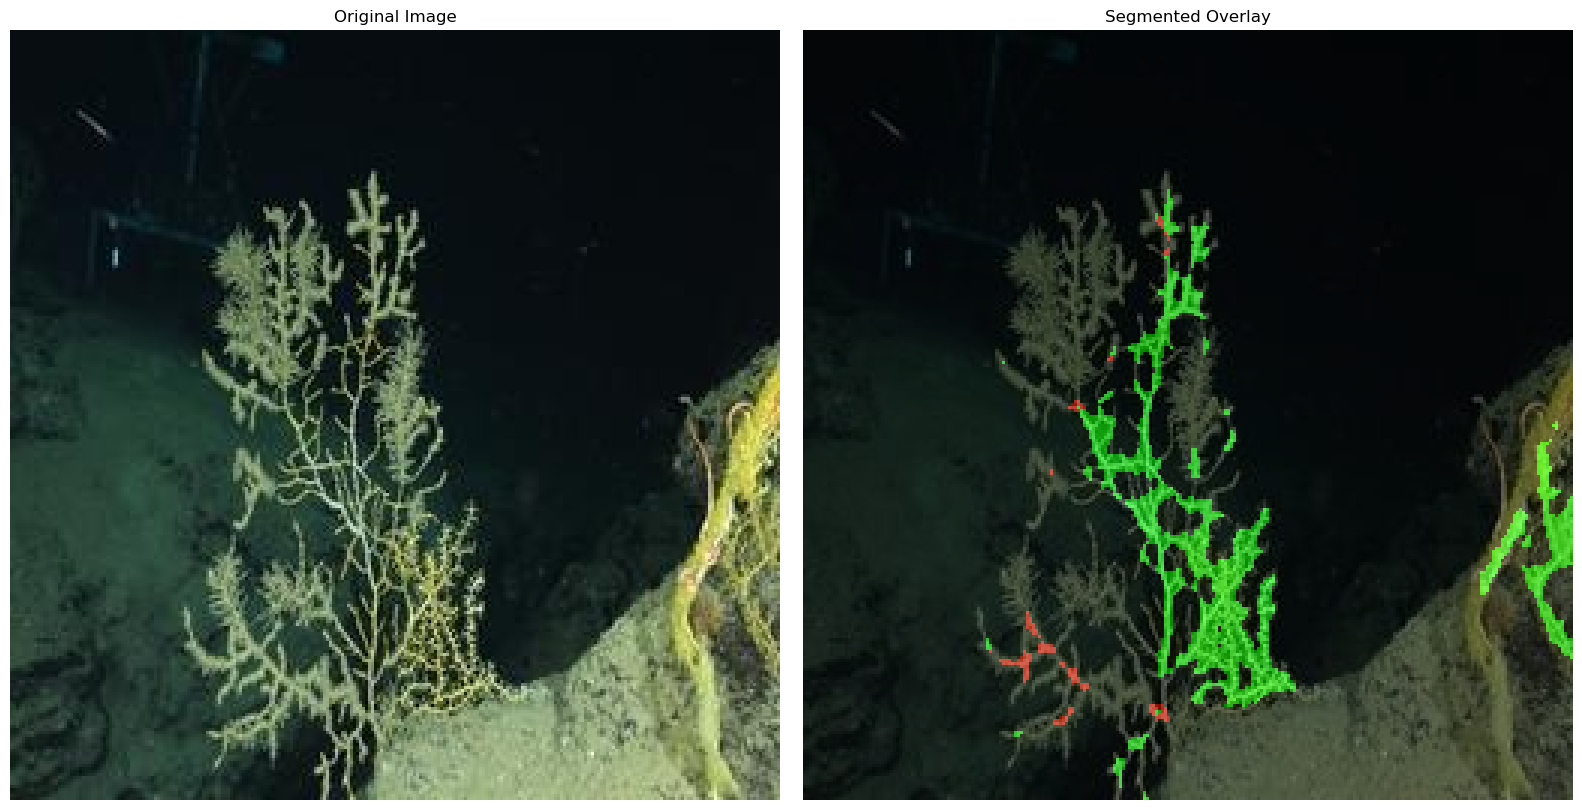

In [38]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline

# === SETUP ===

# Path to image directory
image_dir = "/mnt/lustre/koa/lab/benthic_ecology_group/Jack/coral_seg/Data Preprocessing/normalized_images copy/"

# Load a random image
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
random_image_file = random.choice(image_files)
image_path = os.path.join(image_dir, random_image_file)
print(f"🖼️ Using image: {random_image_file}")
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# === SEGMENTATION PIPELINE ===
segmenter = pipeline(
    task="image-segmentation",
    model="jackhowell/segformer-coral-segmentation"
)

results = segmenter(image)

# === ID2LABEL AND PALETTE ===

# You must define this to match your training config
id2label = {
    0: "background",
    1: "hy",
    2: "nh",
    3: "nv",
    4: "st-zo",
    5: "ns"
}

# Reverse mapping: label name → ID
label2id = {v: k for k, v in id2label.items()}

# Define color palette
palette = {
    0: [0, 0, 0],         # background - black
    1: [255, 255, 0],     # hy - yellow
    2: [255, 0, 0],       # nh - red
    3: [0, 255, 0],       # nv - green
    4: [0, 255, 255],     # st-zo - cyan
    5: [128, 0, 128]      # ns - purple
}

# === BUILD SEGMENTATION OVERLAY ===

segmentation_map = np.zeros_like(image_np)

for result in results:
    mask = np.array(result["mask"])  # bool array
    label_name = result["label"]
    label_id = label2id.get(label_name, 0)  # default to background if unknown
    color = palette[label_id]
    
    for c in range(3):  # RGB
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

import matplotlib.pyplot as plt

# Plot original and overlay side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original image
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Segmented overlay
axes[1].imshow(image_np)
axes[1].imshow(segmentation_map, alpha=0.5)
axes[1].set_title("Segmented Overlay")
axes[1].axis('off')

plt.tight_layout()
plt.show()

The model has generated some masks, so we can visualize them to evaluate and understand its performance. This will help us see how well the model is segmenting the images and identify any areas for improvement.


## 11. Evaluate Performance on the Test Set 📊


In [26]:
metrics = trainer.evaluate(test_ds)
print(metrics)

{'eval_loss': 0.31523895263671875, 'eval_mean_iou': 0.06242437300513578, 'eval_mean_accuracy': 0.07806740402496373, 'eval_overall_accuracy': 0.32100442179389915, 'eval_accuracy_background': nan, 'eval_accuracy_hy': 0.0, 'eval_accuracy_nh': 0.0, 'eval_accuracy_nv': 0.3903370201248187, 'eval_accuracy_st-zo': 0.0, 'eval_accuracy_ns': 0.0, 'eval_iou_background': 0.0, 'eval_iou_hy': 0.0, 'eval_iou_nh': 0.0, 'eval_iou_nv': 0.37454623803081466, 'eval_iou_st-zo': 0.0, 'eval_iou_ns': 0.0, 'eval_runtime': 1.776, 'eval_samples_per_second': 37.724, 'eval_steps_per_second': 5.067, 'epoch': 3.5294117647058822}


In [27]:
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Load model and processor
model = SegformerForSemanticSegmentation.from_pretrained("jackhowell/segformer-coral-segmentation")
processor = SegformerImageProcessor.from_pretrained("jackhowell/segformer-coral-segmentation")

# Load image
image_path = "/mnt/lustre/koa/lab/benthic_ecology_group/Jack/coral_seg/Data Preprocessing/normalized_images copy/task_140.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocess
inputs = processor(images=image, return_tensors="pt")
model.eval()

# Run inference and compute softmax probabilities
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)  # (1, num_classes, H, W)

# Your class labels
id2label = model.config.id2label

# Compute and print average confidence per class
for class_id, label in id2label.items():
    class_score = probs[0, class_id].mean().item()
    print(f"Label: {label:<10} | Avg Confidence: {class_score:.4f}")

Label: background | Avg Confidence: 0.9099
Label: hy         | Avg Confidence: 0.0073
Label: nh         | Avg Confidence: 0.0079
Label: nv         | Avg Confidence: 0.0628
Label: st-zo      | Avg Confidence: 0.0064
Label: ns         | Avg Confidence: 0.0058
